In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.cluster import DBSCAN,Birch
import warnings

from yellowbrick.cluster import KElbowVisualizer

## ONLY USING CUSTOMERS AND TRANSACTION TABLE (NOT PRODUCT TABLE) AS MENTIONED IN PDF

In [2]:
Customers = pd.read_csv("Customers.csv")
Transactions = pd.read_csv("Transactions.csv")

In [9]:
merged_df = Transactions.merge(Customers, on='CustomerID')

In [10]:
merged_df.shape

(1000, 10)

In [11]:
# Account Age (Days)
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['AccountAge'] = (pd.to_datetime('today') - merged_df['SignupDate']).dt.days

In [12]:
# Total Spend per Customer
customer_total_spend = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_total_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

In [13]:
# Total Transaction Count per Customer
customer_transaction_count = merged_df.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transaction_count.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)


In [14]:
# Average Spend per Transaction
customer_avg_spend = merged_df.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_spend.rename(columns={'TotalValue': 'AvgSpend'}, inplace=True)

In [15]:
# Merge these features back into the main dataframe
merged_df = merged_df.merge(customer_total_spend, on='CustomerID', how='left')
merged_df = merged_df.merge(customer_transaction_count, on='CustomerID', how='left')
merged_df = merged_df.merge(customer_avg_spend, on='CustomerID', how='left')

In [16]:
# Frequency of Purchases (per day)
merged_df['Frequency'] = merged_df['TransactionCount'] / merged_df['AccountAge']

In [17]:
# Average Quantity per Transaction
customer_avg_quantity = merged_df.groupby('CustomerID')['Quantity'].mean().reset_index()
customer_avg_quantity.rename(columns={'Quantity': 'AvgQuantity'}, inplace=True)
merged_df = merged_df.merge(customer_avg_quantity, on='CustomerID', how='left')

In [18]:
# Recency of Last Purchase (in days)
last_purchase_date = merged_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase_date['LastPurchaseRecency'] = (pd.to_datetime('today') - pd.to_datetime(last_purchase_date['TransactionDate'])).dt.days
merged_df = merged_df.merge(last_purchase_date[['CustomerID', 'LastPurchaseRecency']], on='CustomerID', how='left')

In [19]:
# Merge region-specific features if needed (average spend per region, etc.)
region_avg_spend = merged_df.groupby('Region')['TotalValue'].mean().reset_index()
region_avg_spend.rename(columns={'TotalValue': 'RegionAvgSpend'}, inplace=True)
merged_df = merged_df.merge(region_avg_spend, on='Region', how='left')

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TransactionID        1000 non-null   object        
 1   CustomerID           1000 non-null   object        
 2   ProductID            1000 non-null   object        
 3   TransactionDate      1000 non-null   object        
 4   Quantity             1000 non-null   int64         
 5   TotalValue           1000 non-null   float64       
 6   Price                1000 non-null   float64       
 7   CustomerName         1000 non-null   object        
 8   Region               1000 non-null   object        
 9   SignupDate           1000 non-null   datetime64[ns]
 10  AccountAge           1000 non-null   int64         
 11  TotalSpend           1000 non-null   float64       
 12  TransactionCount     1000 non-null   int64         
 13  AvgSpend             1000 non-null

In [22]:
customer_data = merged_df[['CustomerID', 'AccountAge','TotalSpend', 'TransactionCount', 'AvgSpend', 'Frequency', 
                      'AvgQuantity','LastPurchaseRecency','Region']]

In [23]:
customer_data.drop(columns=(['CustomerID']), inplace = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_24832\4230973724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data.drop(columns=(['CustomerID']), inplace = True)


In [25]:
customer_data = customer_data.drop_duplicates().reset_index()

In [26]:
customer_data.shape

(199, 9)

In [27]:
#Get list of categorical variables
s = (customer_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)


Categorical variables in the dataset: ['Region']


In [28]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    customer_data[i]=customer_data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [29]:
customer_data.shape

(199, 9)

In [30]:
customer_data.drop(columns=(['index']), inplace = True)

In [31]:
ds = customer_data.copy()
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [32]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,AccountAge,TotalSpend,TransactionCount,AvgSpend,Frequency,AvgQuantity,LastPurchaseRecency,Region
0,0.700146,-0.813993,-0.467494,-0.812176,-0.548521,-0.501206,-0.159689,-0.534131
1,-1.269419,-0.490416,-0.467494,-0.189098,0.526224,-0.947444,-0.908904,-1.419897
2,-0.799304,-0.128242,0.444578,-0.626814,0.161301,-1.244935,0.349213,-0.534131
3,-0.820813,1.715974,0.900614,1.078130,0.346165,1.092499,0.434029,1.237402
4,1.508251,-0.186987,-0.467494,0.395184,-0.608385,0.837506,0.108898,-0.534131


## Dimensionality Reduction

In [33]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(ds)
PCA_ds = pd.DataFrame(pca.transform(ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,199.0,-2.010943e-13,1837.661155,-3417.216197,-1310.966773,-330.988406,1317.319995,7215.966268
col2,199.0,-7.026875e-14,326.815878,-553.959138,-278.928477,-24.274479,294.303885,551.075796
col3,199.0,1.553911e-13,197.089132,-343.456650,-127.466115,-40.655011,120.094296,643.750288


In [41]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AccountAge           199 non-null    int64  
 1   TotalSpend           199 non-null    float64
 2   TransactionCount     199 non-null    int64  
 3   AvgSpend             199 non-null    float64
 4   Frequency            199 non-null    float64
 5   AvgQuantity          199 non-null    float64
 6   LastPurchaseRecency  199 non-null    int64  
 7   Region               199 non-null    int32  
 8   clusters_kmeans      199 non-null    int32  
dtypes: float64(4), int32(2), int64(3)
memory usage: 12.6 KB


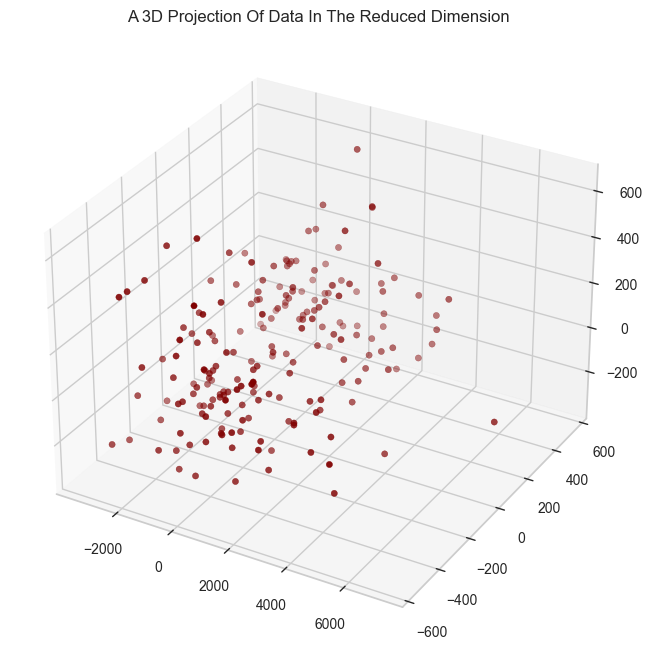

In [42]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

## KMeans

Elbow Method to determine the number of clusters to be formed:


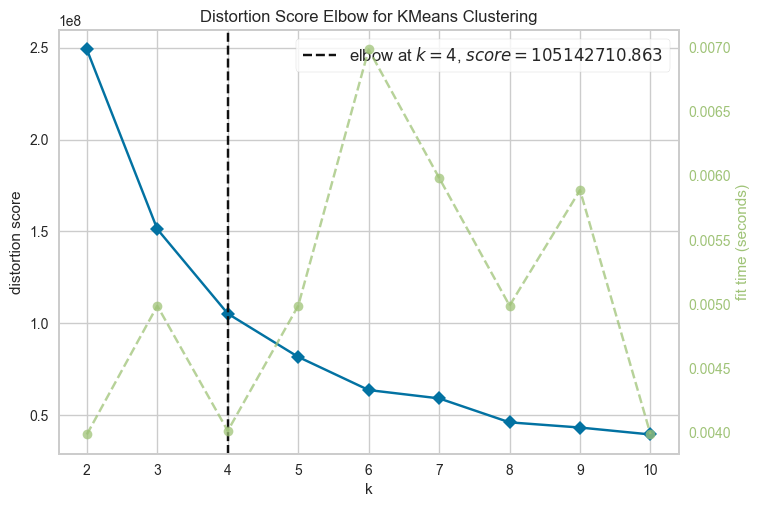

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

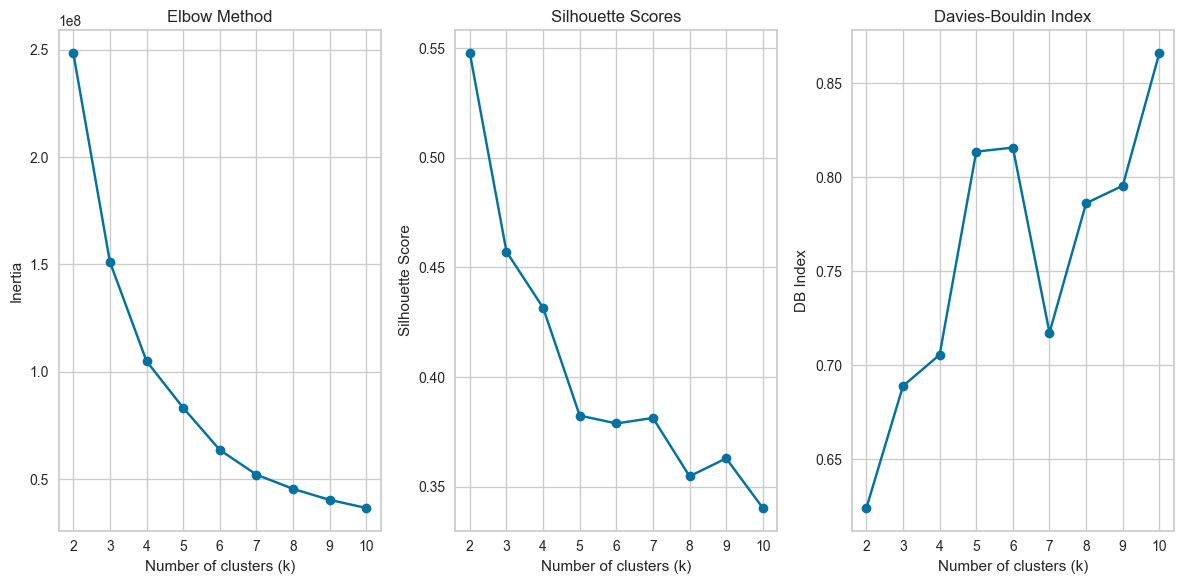

In [77]:
inertia = []
silhouette_scores = []
db_indices = []
k_values = range(2, 11)  # Test for k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(PCA_ds)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(PCA_ds, kmeans.labels_))
    db_indices.append(davies_bouldin_score(PCA_ds, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(2,11))

# Plotting Silhouette Scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2,11))

# Plotting Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, db_indices, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters (k)')
plt.ylabel('DB Index')
plt.xticks(range(2,11))

plt.tight_layout()
plt.show()


## lets consider number of cluster 4 as suggested by the ELBOW Method

In [78]:
def db_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    # print(f"DB Index during GridSearch: {score}")
    return -score  # Negate for minimization

# Parameter grid
param_grid = {
    'n_clusters': [4],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500],
    'tol': [1e-4, 1e-3]
}

kmeans = KMeans(random_state=42)

warnings.filterwarnings("ignore")
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring=db_scorer, cv=3, verbose=1)
grid_search.fit(PCA_ds)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Lowest DB Index (GridSearch): {-best_score}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 4, 'n_init': 10, 'tol': 0.0001}
Lowest DB Index (GridSearch): 0.6920831805531117


In [106]:
# Final model on entire dataset
final_kmeans = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    n_init=best_params['n_init'],
    max_iter=best_params['max_iter'],
    tol=best_params['tol'],
    random_state=42
)
final_kmeans.fit(PCA_ds)
final_db_index = davies_bouldin_score(PCA_ds, final_kmeans.labels_)
print(f"Final DB Index on Full Dataset: {final_db_index}")

Final DB Index on Full Dataset: 0.7441834025664829


In [80]:
customer_data['clusters_kmeans'] = final_kmeans.fit_predict(PCA_ds)

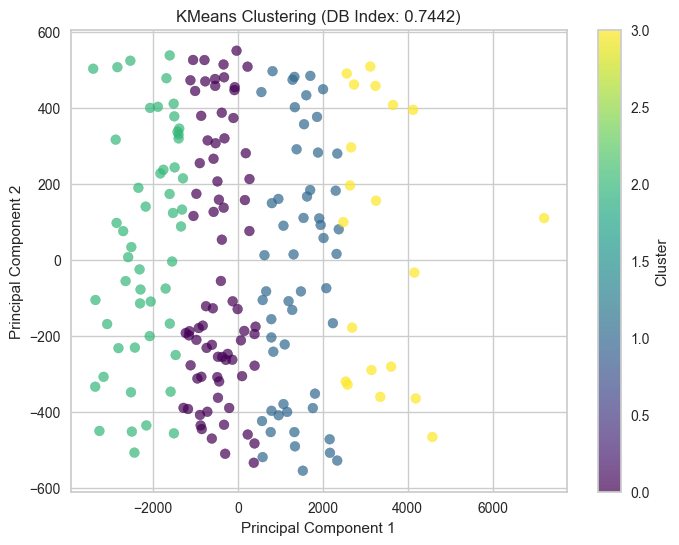

In [81]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(PCA_ds)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_kmeans.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title(f"KMeans Clustering (DB Index: {final_db_index:.4f})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

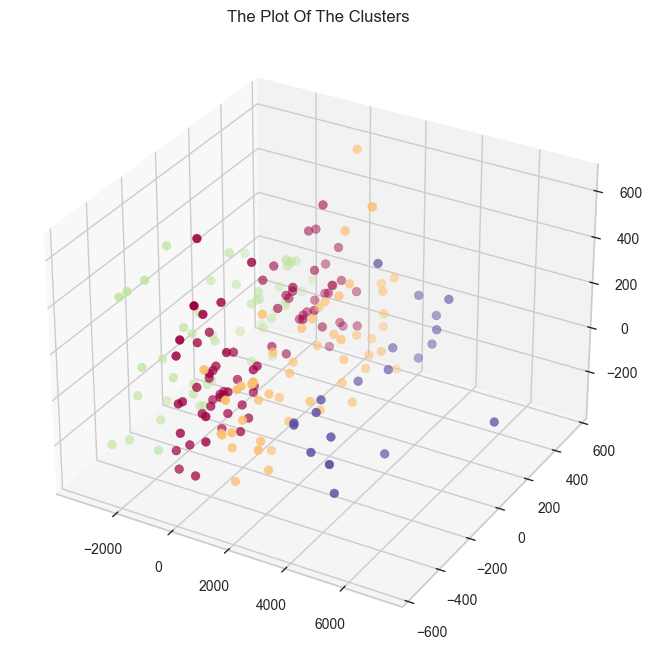

In [82]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=final_kmeans.fit_predict(PCA_ds), marker='o' , cmap = 'Spectral')
ax.set_title("The Plot Of The Clusters")
plt.show()

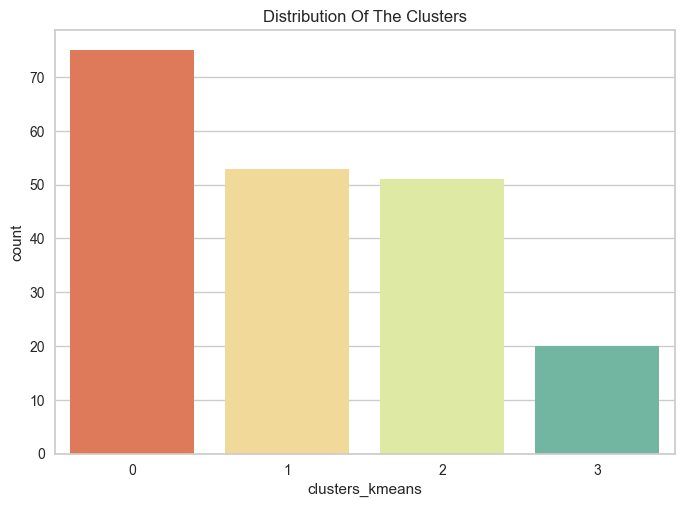

In [83]:
#Plotting countplot of clusters
pl = sns.countplot(x=customer_data["clusters_kmeans"], palette= "Spectral")
pl.set_title("Distribution Of The Clusters")
plt.show()

In [93]:
km_dbi = davies_bouldin_score(PCA_ds, customer_data['clusters_kmeans'])
km_silhouette = silhouette_score(PCA_ds, customer_data['clusters_kmeans'])
km_calinski_harabasz = calinski_harabasz_score(PCA_ds, customer_data['clusters_kmeans'])

print(f'KMeans Davies-Bouldin Index: {km_dbi}')
print(f'KMeans Silhouette Score: {km_silhouette}')
print(f'KMeans Calinski-Harabasz Index: {km_calinski_harabasz}')

KMeans Davies-Bouldin Index: 0.7441834025664829
KMeans Silhouette Score: 0.4280757633687947
KMeans Calinski-Harabasz Index: 369.36486599331795


## Agglomerative Clustering

In [109]:


# Apply Hierarchical Clustering (Agglomerative)
agg_clust = AgglomerativeClustering(n_clusters=2)  # You can adjust n_clusters
customer_data['clustrs_AC'] = agg_clust.fit_predict(PCA_ds)

# Evaluate clustering
ac_dbi = davies_bouldin_score(PCA_ds, customer_data['clustrs_AC'])
ac_silhouette = silhouette_score(PCA_ds, customer_data['clustrs_AC'])
ac_calinski_harabasz = calinski_harabasz_score(PCA_ds, customer_data['clustrs_AC'])

print(f'AC Davies-Bouldin Index: {ac_dbi}')
print(f'AC Silhouette Score: {ac_silhouette}')
print(f'AC Calinski-Harabasz Index: {ac_calinski_harabasz}')


AC Davies-Bouldin Index: 0.5934501402773018
AC Silhouette Score: 0.5387619454901768
AC Calinski-Harabasz Index: 312.16862881756276


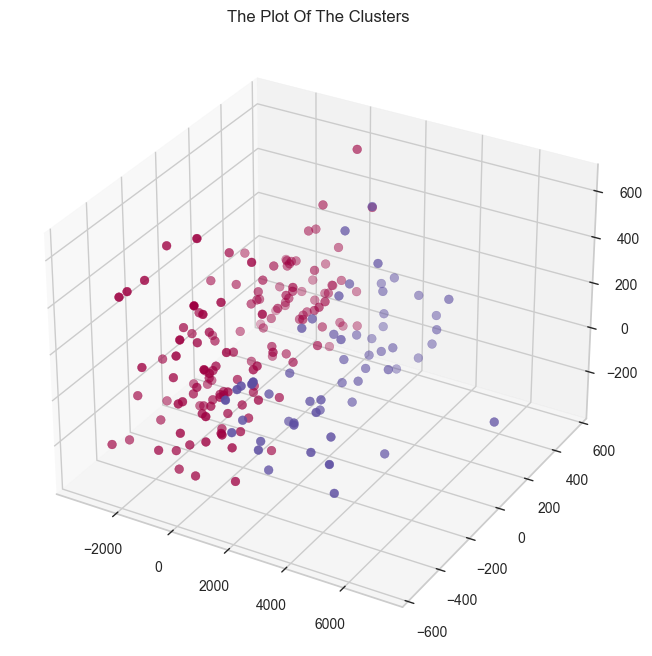

In [110]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=agg_clust.fit_predict(PCA_ds), marker='o' , cmap = 'Spectral')
ax.set_title("The Plot Of The Clusters")
plt.show()

## Birch Clustering

In [87]:
brc = Birch(n_clusters=4)
brc_labels = brc.fit_predict(PCA_ds)
customer_data['brc_clusters'] = brc_labels

In [91]:
# Evaluate clustering
brc_dbi = davies_bouldin_score(PCA_ds, customer_data['brc_clusters'])
brc_silhouette = silhouette_score(PCA_ds, customer_data['brc_clusters'])
brc_calinski_harabasz = calinski_harabasz_score(PCA_ds, customer_data['brc_clusters'])

print(f'AC Davies-Bouldin Index: {brc_dbi}')
print(f'AC Silhouette Score: {brc_silhouette}')
print(f'AC Calinski-Harabasz Index: {brc_calinski_harabasz}')


AC Davies-Bouldin Index: 0.747573792302995
AC Silhouette Score: 0.38484613026962544
AC Calinski-Harabasz Index: 307.8773288093128


## Results 

In [96]:
results = pd.DataFrame({
    'KMeans': [km_dbi, km_silhouette, km_calinski_harabasz],
    'Agglomerative': [ac_dbi, ac_silhouette, ac_calinski_harabasz],
    'Birch': [brc_dbi, brc_silhouette, brc_calinski_harabasz]
}, index=['Davies-Bouldin Index', 'Silhouette Score', 'Calinski-Harabasz Score'])

print(results)

                             KMeans  Agglomerative       Birch
Davies-Bouldin Index       0.744183       0.731018    0.747574
Silhouette Score           0.428076       0.393890    0.384846
Calinski-Harabasz Score  369.364866     362.479822  307.877329


## Kmeans have best performance 

## Profiling

In [89]:
cluster_summary = customer_data.groupby('clusters_kmeans').agg({
    'TotalSpend': ['sum','mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'LastPurchaseRecency': ['mean', 'median', 'std']
})

# Display the summary
print(cluster_summary)

                TotalSpend                                     Frequency  \
                       sum         mean    median          std      mean   
clusters_kmeans                                                            
0                225481.34  3006.417867  2997.970   465.139954  0.016636   
1                258909.44  4885.083774  4812.100   562.227541  0.025344   
2                 67825.14  1329.904706  1378.170   632.097069  0.007106   
3                137779.64  6888.982000  6656.165  1099.835635  0.020270   

                                    LastPurchaseRecency                     
                   median       std                mean median         std  
clusters_kmeans                                                             
0                0.010526  0.017331           91.666667   93.0   49.297315  
1                0.010870  0.031179           94.075472   93.0   49.751633  
2                0.004444  0.009755          136.941176  101.0  105.499652  
3    

#### Cluster 0: Moderate Spend, Low Frequency, Moderate Recency

Total Spend: $225,481.34 (Moderate)
Frequency: Low (0.0166)
Recency: Moderate (91.67 days)
Profile: Customers in this cluster exhibit moderate spending behavior with infrequent purchases and moderate recency. They engage occasionally, making purchases roughly once every 91 days.
Potential Profile: A segment of moderately engaged customers with intermittent purchases. They could benefit from re-engagement strategies.


#### Cluster 1: High Spend, Moderate Frequency, Moderate Recency

Total Spend: $258,909.44 (High)
Frequency: Moderate (0.0253)
Recency: Moderate (94.08 days)
Profile: High-spending customers who make purchases at a moderate frequency. Their recency is slightly higher than Cluster 0, indicating they might be more recently active.
Potential Profile: High-value customers with regular spending. They could be targeted for loyalty programs or high-ticket product offerings.

    
#### Cluster 2: Low Spend, Very Low Frequency, High Recency

Total Spend: $67,825.14 (Low)
Frequency: Very Low (0.0071)
Recency: High (136.94 days)
Profile: Customers who show very low spending and purchase frequency. They have high recency, suggesting they made a recent purchase but haven’t been active for long.
Potential Profile: Low engagement customers who could be targeted with reactivation campaigns, potentially offering incentives to bring them back.

                                                                                                                                                    
#### Cluster 3: High Spend, Moderate Frequency, Recent Purchases

Total Spend: $137,779.64 (High)
Frequency: Moderate (0.0203)
Recency: Recent (65.65 days)
Profile: These customers spend a lot, with moderate frequency and recent purchases. They show a solid engagement level and are recent buyers, meaning they are highly active.
Potential Profile: High-value, active customers, perfect for upselling or introducing premium products.
                                                                                                                                                     
                                                                                                                                                     
                                                                                                                                                     
